# Using James and Thomas work, we can easily get Data (THANKS GUYS!!! :))

Going to test our binary classification on the satellite images to reflect the presence and absence of rice crops. 

Data can be found at:  https://drive.google.com/open?id=1HZBJsVfDDQ8nAFIDZrRIW04hdthmY0Ns

In [0]:
!pip install fastprogress
!wget -O gdrive https://docs.google.com/uc?id=0B3X9GlR6EmbnWksyTEtCM0VfaFE&export=download 
!chmod +x gdrive
!sudo install gdrive /usr/local/bin/gdrive


In [0]:
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
import numpy as np
from os import scandir, walk, remove
import pandas as pd
from fastprogress import progress_bar
from fastai import *
from fastai.vision import *
from PIL import Image


In [0]:
## Execute olny once if files saved to GDrive storage

#Guess where did I get this from (hint its somewhere up there)
!gdrive download 1HZBJsVfDDQ8nAFIDZrRIW04hdthmY0Ns

In [0]:
%cd /content
!unzip WFP_Nepal_RGB-Scale3.5_PNG.zip
%rm -rf /content/__MACOSX

In [0]:
def center_crop(img, new_width=64, new_height=None):        
    width = img.width
    height = img.height

    if new_height is None:
        new_height = new_width

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))
   
    center_cropped_img = img.crop((left, top, right, bottom))
    assert((center_cropped_img.height == new_height) and (center_cropped_img.width == new_width))

    return center_cropped_img

def crop_on_img(filename, path_target, size=41):
    img = Image.open(filename)
    img = center_crop(img, size, size)
    img.save(path_target+filename.stem+'.png')

In [0]:
def do(file,i):
  crop_on_img(file, path_target, 512)

In [0]:
LAUNCH = True
# Path where your downloaded data is
path_source = '/content/WFP_Nepal_RGB-Scale3.5_PNG/'

# Target path of resized data
%mkdir -p /content/WFP_Nepal_RGB-Scale3.5_PNG/CenteredCropped
path_target = '/content/WFP_Nepal_RGB-Scale3.5_PNG/CenteredCropped/'

# in case i want to use data stored in Gdrive... but it gets desconnected pretty often
#path_target = '/content/drive/My\ Drive/colab_projects/NepalImages/CenteredCropped/'

files = ImageList.from_folder(path_source).items

## compute (crop/center) our files
parallel(do,files)

In [0]:
# # copy created files to your Gdrive

# # create master dir on my Drive
# %mkdir -p /content/drive/My\ Drive/colab_projects/NepalImages
# # copy processed files there
# %cp -r /content/WFP_Nepal_RGB-Scale3.5_PNG/CenteredCropped /content/drive/My\ Drive/colab_projects/NepalImages/


# Import necessary libraries (also tensorflow v. 2.0 )

In [0]:
# from __future__ import absolute_import, division, print_function, unicode_literals
# # read files and directory structure, 
# # numpy is used to convert python list to numpy array and to perform required matrix operations and 
# # matplotlib.pyplot is used to plot the graph and display images in our training and validation data.
# import os
# import numpy as np
# import glob
# import shutil
# import matplotlib.pyplot as plt
# import datetime

In [0]:
# # upgrade to TF 2.0 with GPU support and import TF 
# !pip install -q tensorflow-gpu==2.0.0-beta1
# import tensorflow as tf

# print(tf.__version__)
# print("GPU Available: ", tf.test.is_gpu_available())

In [0]:
# tf.debugging.set_log_device_placement(True)

# # Create some tensors
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# print(c)

In [0]:
# import logging
# logger = tf.get_logger()
# logger.setLevel(logging.ERROR)

In [0]:
# # print("keras veersion", tf.keras.__version__)
# from keras.preprocessing.image import ImageDataGenerator

# Get data description file

In [22]:
# download data labels and descriptors
!gdrive download 1AU7pZVL5xDotl13jCaoT7a2xwZUZfiT2

Downloaded 1AU7pZVL5xDotl13jCaoT7a2xwZUZfiT2 at 726.0 KB/s, total 726.0 KB


In [0]:
trn_val = pd.read_csv("train_test_split.csv")

In [28]:
trn_val_dict = {row.fname: row.is_val_set for _, row in trn_val.iterrows()}
print(trn_val_dict)

{'rice_Oct16_84-28306358_27-59084298_img_0.png': False, 'rice_Oct16_84-526036_27-60306972_img_2.png': False, 'rice_Aug16_84-5499051_27-66798481_img_0.png': True, 'other_Oct16_84-52634599_27-58503432_img_1.png': False, 'other_Nov16_84-5851412_27-6099488_img_4.png': False, 'other_Nov16_84-25636492_27-5949023_img_0.png': False, 'rice_Feb17_85-64941639_27-56884986_img_2.png': False, 'other_Nov16_84-6021897_27-58628348_img_1.png': True, 'other_Jan17_85-72360112_27-43425935_img_1.png': False, 'rice_Oct16_84-54014659_27-65430335_img_0.png': False, 'other_Aug16_84-6216815_27-63639669_img_2.png': True, 'rice_Mar17_85-53799504_27-56916064_img_0.png': False, 'rice_Mar17_84-19713364_27-59366022_img_1.png': False, 'other_Oct16_84-68641427_27-68245071_img_3.png': False, 'rice_Oct16_84-37956552_27-59176428_img_0.png': False, 'rice_Mar17_84-38279272_27-60176285_img_0.png': True, 'other_Nov16_84-5851412_27-6099488_img_3.png': False, 'rice_Oct16_84-3995528_27-59626195_img_0.png': True, 'rice_Feb17_85-54

In [0]:
import re
pat = '^rice_'

def is_rice(fname):
  if re.search(pat,fname.stem): return True
  return False

In [0]:
def get_split(fname):
#   return trn_val.loc[trn_val['fname'] == fname.name]['is_val_set'].values[0]
  print(fname.name)
  return trn_val_dict[fname.name]

In [0]:
# load data sets
src = (ImageList.from_folder(Path(path_target))
        .split_by_valid_func(get_split)
        .label_from_func(is_rice)
      )
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms,size=224)
        .databunch(bs=40)
        .normalize(imagenet_stats)
       )

# ImageNet pretrainet (PyTorch implementation)

In [32]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built pretrainedmodels munch


In [0]:
import pretrainedmodels

In [34]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [35]:
print(pretrainedmodels.pretrained_settings['inceptionv3'])

{'imagenet': {'url': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1000}}


In [0]:
# - `inceptionresnetv2(num_classes=1000, pretrained='imagenet')`
# - `inceptionresnetv2(num_classes=1001, pretrained='imagenet+background')`
# - `inceptionv4(num_classes=1000, pretrained='imagenet')`
# - `inceptionv4(num_classes=1001, pretrained='imagenet+background')`
# - `inceptionv3(num_classes=1000, pretrained='imagenet')`

In [0]:
def f1_score(y_pred:Tensor, y_true:Tensor,beta:float=1, eps:float=1e-9)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2

    y_pred = y_pred.argmax(dim=1).float()
    y_true = y_true.float()
    
    TP = (y_pred*y_true).sum()
    prec = TP/(y_pred.sum()+eps)
    rec = TP/(y_true.sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [0]:
import torch
import pretrainedmodels.utils as utils

In [0]:
model = pretrainedmodels.__dict__['inceptionv4'](num_classes=1000, pretrained='imagenet')

In [0]:
# Lets see which groups of the model are responsible for feature extraction part (Conv Layers), and which for classification part (fully connected (i.e. no more convolutions)))
model.eval()

In [0]:
# Inceptionv4 model has Classification part in the last linear_layer, and  
learn = Learner(data, model, metrics=[accuracy, f1_score])


# based on model.eval() printed before, all groups before last one are for feature extraction, and only  the last one is a classificator
# the goal behind splitting groups, is to be able to freeze up the first one (feature extractor) at the initial classificator training - while looking for appropriate learning rate 
groups = [nn.Sequential(*list(model.children())[:-1]),nn.Sequential(*list(model.children())[-1:])]
learn.layer_groups = groups


# at first we need to train only a classifier. so we want to left the pretrained feature extractor part untouched. this is to prevent instability
# because if you train the whole model together, and one part of it is good, and one part is bad then during training, although the bad part is going to improve, 
# it might also slightly hurt the good part
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 2.09E-02


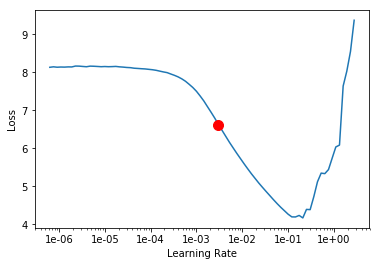

In [46]:
# How to use the Learning Rate Finder in TensorFlow
# https://medium.com/octavian-ai/how-to-use-the-learning-rate-finder-in-tensorflow-126210de9489
# reaserch paper: https://arxiv.org/pdf/1506.01186.pdf
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [50]:
groups = [nn.Sequential(*list(model.children())[:-1]),nn.Sequential(*list(model.children())[-1:])]
learn.layer_groups = groups
learn.freeze()

# The 1cycle policy - fit_one_cycle() explained
# https://sgugger.github.io/the-1cycle-policy.html
learn.fit_one_cycle(4,3e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.741270,0.745196,0.608330,0.392637,04:03
1,0.654435,0.633675,0.642721,0.547088,03:50
2,0.604020,0.650472,0.645778,0.587376,03:50
3,0.584740,0.720312,0.631257,0.476402,03:57


In [0]:
# now, after finding the promissing classifier learning rate, we can unfreeze the network to improve both parts of the network  
learn.unfreeze()

# when you unfreeze, pytorch calculates gradients for the entire model, hence we need more memory
# so even if halving the batch size could be a bit too agresive, that's the rule of the thumb that we go for without much consideration... 
learn.data.batch_size =learn.data.batch_size //2

In [59]:
print(datetime.datetime.now())

# ‘slice’ is giving different learning rates for different layers/groups. one for the Conv part, and second for Classfier part
# cls we use the old rate divided by 10
# for conv maybe divide by 100
learn.fit_one_cycle(15,slice(3e-5,3e-4))

print(datetime.datetime.now())

2019-07-09 12:56:56.668137


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.382627,0.547312,0.731754,0.663694,05:47
1,0.385781,0.611034,0.726404,0.652960,05:47
2,0.391194,0.603436,0.730225,0.654365,05:48
3,0.383255,0.641539,0.722965,0.647588,05:47
4,0.393764,1.068737,0.732136,0.666385,05:48
5,0.335391,0.604432,0.760413,0.722765,05:47
6,0.330991,0.645743,0.738250,0.685576,05:48
7,0.302121,0.683393,0.740925,0.682434,05:48
8,0.257289,0.950059,0.728697,0.641602,05:48
9,0.250944,0.844395,0.737486,0.680311,05:48


2019-07-09 14:23:59.639044


In [0]:
learn.save('v4_1_3e-4')